In [1]:
import os 
import os.path as osp
import numpy as np
import pandas as pd 
import torch as th 
from matplotlib import pyplot as plt 
import sys 


sys.path.append("/mnt/e/Personal/Samarth/repository/RGB_to_3D_conversion/src")
from depth_model.model import PTModel
from data_loader.data_creation import CreateDataset
from utils.data_transforms import pre_process

print(th.cuda.is_available())
device = 'cpu' if th.cuda.is_available() else 'cpu'

True


In [2]:
depth_model = PTModel().to(device)
checkpoint = th.load("../model/depthnet.ckpt")
depth_model.load_state_dict(checkpoint)
depth_model.eval()

/home/samartht/anaconda3/envs/ptorch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/samartht/anaconda3/envs/ptorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


PTModel(
  (encoder): Encoder(
    (original_model): DenseNet(
      (features): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2): _DenseLaye

In [3]:
data_path = "/mnt/e/Personal/Samarth/repository/RGB_to_3D_conversion/Data"
val_df = pd.read_csv(os.path.join(data_path, 'data/nyu2_test.csv'))
val_df.columns = ['RGB_images', 'Depth_images']
val_df = val_df.sample(500)
val_df.head()

,RGB_images,Depth_images
94,data/nyu2_test/00207_colors.png,data/nyu2_test/00207_depth.png
169,data/nyu2_test/00434_colors.png,data/nyu2_test/00434_depth.png
604,data/nyu2_test/01352_colors.png,data/nyu2_test/01352_depth.png
193,data/nyu2_test/00508_colors.png,data/nyu2_test/00508_depth.png
404,data/nyu2_test/00965_colors.png,data/nyu2_test/00965_depth.png


In [4]:
val_rgb_files = [osp.join(data_path, filename) for filename in val_df['RGB_images'].to_list()]
val_depth_files = [osp.join(data_path, filename) for filename in val_df['Depth_images'].to_list()]


In [5]:
from torch.utils.data import DataLoader
valid_dataset = CreateDataset(rgb_files=val_rgb_files,
                                depth_files=val_depth_files,
                                transform=None,
                                task='validation',
                                process_image=pre_process())
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=1)

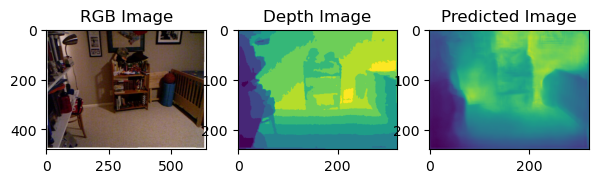

In [8]:
def to_multichannel(i):
    if i.shape[2] == 3: return i
    i = i[:,:,0]
    return np.stack((i,i,i), axis=2)

def tensor_to_numpy_image(image,rgb=True):
    image = image.permute(1,0,2,3).squeeze(axis=0).cpu().detach().numpy()
    if rgb:
        image = image.squeeze(axis=1)
        return np.array(image.transpose(1, 2, 0)*255, dtype=np.uint8) 
    
    else:
        return image.squeeze(axis=0)*255.0

def DepthNorm(x, maxDepth):
    return maxDepth / x


plt.figure(figsize=(7,15))

for i, sample_batch in enumerate(valid_loader):
    
    image = sample_batch['image'].to(device)
    depth = sample_batch['depth'].to(device)
    
    y_pred = depth_model(sample_batch['image'].to(device))
    y_pred = tensor_to_numpy_image(y_pred,rgb=False)
    y_pred = DepthNorm(y_pred,100)*255
    
    depth_image = tensor_to_numpy_image(depth,rgb=False)

    resize_image =  tensor_to_numpy_image(image) # , shape, preserve_range=True, mode='reflect', anti_aliasing=True )
    plt.subplot(1,3,1)
    plt.title("RGB Image")
    plt.imshow(resize_image)
    
    plt.subplot(1,3,2)
    plt.title("Depth Image")
    plt.imshow(depth_image)

    plt.subplot(1,3,3)
    plt.title("Predicted Image")
    plt.imshow(y_pred)  

    if i == 4:
        break
    

### Fine Tune Model

In [20]:
# save layer names
layer_names = []
for idx, (name, param) in enumerate(depth_model.named_parameters()):
    layer_names.append(name)
# Getting the depth layers for decoder 
# reverse layers
layer_names.reverse()
print(layer_names[0:20])
            

['decoder.conv3.bias', 'decoder.conv3.weight', 'decoder.up4.convB.bias', 'decoder.up4.convB.weight', 'decoder.up4.convA.bias', 'decoder.up4.convA.weight', 'decoder.up3.convB.bias', 'decoder.up3.convB.weight', 'decoder.up3.convA.bias', 'decoder.up3.convA.weight', 'decoder.up2.convB.bias', 'decoder.up2.convB.weight', 'decoder.up2.convA.bias', 'decoder.up2.convA.weight', 'decoder.up1.convB.bias', 'decoder.up1.convB.weight', 'decoder.up1.convA.bias', 'decoder.up1.convA.weight', 'decoder.conv2.bias', 'decoder.conv2.weight']


## Fine Tune with LR 
The key idea is to gradually reduce the learning rate when going deeper into the network. The first layers should already have a pretty good understanding of general domain-agnostic patterns after pre-training. In a computer vision setting, the first layers may have learned to distinguish simple shapes and edges; in natural language processing, the first layers may be responsible for general word relationships. We don't want to update parameters on the first layers too much, so it makes sense to reduce the corresponding learning rates. In contrast, we would like to set a higher learning rate for the final layers, especially for the fully-connected classifier part of the network. Those layers usually focus on domain-specific information and need to be trained on new data.

In [ ]:
def fine_tune(pretrined_model):
    # save layer names
    layer_names = []
    for idx, (name, param) in enumerate(pretrined_model.named_parameters()):
        layer_names.append(name)
    # Getting the depth layers for decoder 
    # reverse layers
    layer_names.reverse()

    # learning rate
    lr      = 1e-2
    lr_mult = 0.9
    # placeholder
    parameters = []

    # store params & learning rates
    for idx, name in enumerate(layer_names):
        # append layer parameters
        parameters += [{'params': [p for n, p in pretrined_model.named_parameters() if n == name and p.requires_grad],
                        'lr':     lr}]
        # update learning rate
        lr *= lr_mult
    return parameters

### fine_tune
checkpoint = th.load("../model/depthnet.ckpt") 
depth_model.load_state_dict(checkpoint)
parameters  = fine_tune(pretrined_model=depth_model)
print(th.optim.Adam(parameters))

## Run the train pipeline thereafter 

# Run the train.py with --pretrained argument 
os.system("python train.py --model_name depth_modelv2 --path ../Data/ --outdir ../model/ --pretrained ../model/depthnet.ckpt")